In [10]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
#%matplotlib inline

In [11]:
def getAcc( pos, mass, G, softening ):
    """
    Calculate the acceleration on each particle due to Newton's Law 
    pos  is an N x 3 matrix of positions
    mass is an N x 1 vector of masses
    G is Newton's Gravitational constant
    softening is the softening length
    a is N x 3 matrix of accelerations
    """
    # positions r = [x,y,z] for all particles
    x = pos[:,0:1]
    y = pos[:,1:2]
    z = pos[:,2:3]
        
    # matrix that stores all pairwise particle separations: r_j - r_i
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

    # matrix that stores 1/r^3 for all particle pairwise particle separations 
    inv_r3 = (dx**2 + dy**2 + dz**2 + softening**2)
    inv_r3[inv_r3>0] = inv_r3[inv_r3>0]**(-1.5)

    ax = G * (dx * inv_r3) @ mass 
    ay = G * (dy * inv_r3) @ mass 
    az = G * (dz * inv_r3) @ mass 

    # pack together the acceleration components
    a = np.hstack((ax,ay,az))

    return a

In [12]:
def collision(pos, vel, n_baryons, sigma_b_b=0, sigma_b_dm=0):
    """
    Returns the indices of the particles that had collisions 
    as well as the post-collision velocities of each particle 
    that experienced a collision.
    """
    N = pos.shape[0];
    collided=[]
    final_vel=[]
    for i in range(N):
        for j in range(1,n_baryons):
            if i!=j:
                dx = pos[j,0] - pos[i,0];
                dy = pos[j,1] - pos[i,1];
                dz = pos[j,2] - pos[i,2];
                
                radius = sigma_b_b if i < n_baryons else sigma_b_dm
          
                if (dx**2 + dy**2 + dz**2) <= radius**2:
                    collided.append(i)
                    collided.append(j)
                    veli, velj = finalVelocities(pos[i], pos[j], vel[i], vel[j])
                    final_vel.append(veli)
                    final_vel.append(velj)

    return collided, final_vel
                
    

In [13]:
def normal(pos1, pos2):
    """
    Given two position vectors, returns the vector normal to their separation
    """
    pos_rel = np.array([pos1[0]-pos2[0], pos1[1]-pos2[1], pos1[2]-pos2[2]])
    pos_rel_mag = np.sqrt(pos_rel[0]**2+pos_rel[1]**2+pos_rel[2]**2)
    return pos_rel/pos_rel_mag

In [14]:
def v_rel(vel1, vel2):
    """
    Returns relative velocity of two particles
    """
    return np.array([vel1[0]-vel2[0], vel1[1]-vel2[1], vel1[2]-vel2[2]])

In [15]:
def v_norm(vel_rel, norm):
    """
    Returns the normal velocity of two particles colliding
    """
    return np.dot(vel_rel, norm)*norm

In [16]:
def finalVelocities(pos1, pos2, vel1, vel2):
    """
    Returns the final velocities of two particles after a collision
    """
    vel_norm=v_norm(v_rel(vel1, vel2), normal(pos1, pos2))
    return vel1-vel_norm, vel2+vel_norm

In [17]:
def getEnergy( pos, vel, mass, G ):
    """
    Get kinetic energy (KE) and potential energy (PE) of simulation
    pos is N x 3 matrix of positions
    vel is N x 3 matrix of velocities
    mass is an N x 1 vector of masses
    G is Newton's Gravitational constant
    KE is the kinetic energy of the system
    PE is the potential energy of the system
    """
    # Kinetic Energy:
    KE = 0.5 * np.sum(np.sum( mass * vel**2 ))


    # Potential Energy:

    # positions r = [x,y,z] for all particles
    x = pos[:,0:1]
    y = pos[:,1:2]
    z = pos[:,2:3]

    # matrix that stores all pairwise particle separations: r_j - r_i
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

    # matrix that stores 1/r for all particle pairwise particle separations 
    inv_r = np.sqrt(dx**2 + dy**2 + dz**2)
    inv_r[inv_r>0] = 1.0/inv_r[inv_r>0]

    # sum over upper triangle, to count each interaction only once
    PE = G * np.sum(np.sum(np.triu(-(mass*mass.T)*inv_r,1)))

    return KE, PE;

In [56]:
def main():
    """ N-body simulation """
    # Simulation parameters
    N         = 100    # Number of particles
    t         = 0      # current time of the simulation
    tEnd      = 5.0   # time at which simulation ends
    dt        = 0.01   # timestep
    softening = 0.1    # softening length
    G         = 1.0    # Newton's Gravitational Constant
    sigma_b_b    = 0.2 # distance that represents how strongly baryons interact with each other (cross section equivalent)
    sigma_b_dm = 0.1 # cross section equivalent for baryon-DM interactions
    plotRealTime = False # switch on for plotting as the simulation goes along
    fBaryon = 0.2 # baryon fraction

    # Generate Initial Conditions
    np.random.seed(17)            # set the random number generator seed

    mass = 20.0*np.ones((N,1))/N  # total mass of particles is 20
    pos  = np.random.randn(N,3)   # randomly selected positions and velocities
    vel  = np.random.randn(N,3)
    
    # select baryons
    n_baryon = int(N*fBaryon)

    # Convert to Center-of-Mass frame
    vel -= np.mean(mass * vel,0) / np.mean(mass)

    # calculate initial gravitational accelerations
    acc = getAcc( pos, mass, G, softening )

    # calculate initial energy of system
    KE, PE  = getEnergy( pos, vel, mass, G )

    # number of timesteps
    Nt = int(np.ceil(tEnd/dt))

    # save energies, particle orbits for plotting trails
    pos_save = np.zeros((N,3,Nt+1))
    pos_save[:,:,0] = pos
    KE_save = np.zeros(Nt+1)
    KE_save[0] = KE
    PE_save = np.zeros(Nt+1)
    PE_save[0] = PE
    t_all = np.arange(Nt+1)*dt
    collisions = 0 
    initial_cluster, final_cluster= 0,0
    for i in range(N):
        if pos[i,0]<2 and pos[i,1]<2 and pos[i,2]<2 and pos[i,0] > -2 and pos[i,1] > -2 and pos[i,2] > -2:
            initial_cluster += 1

    # prep figure
    fig = plt.figure(figsize=(4,
                              5), dpi=80)
    grid = plt.GridSpec(3, 1, wspace=0.0, hspace=0.3)
    ax1 = fig.add_subplot(grid[0:2,0], projection='3d')
    ax2 = fig.add_subplot(grid[2,0])

    b_dm_collisions=0
    # Simulation Main Loop
    for i in range(Nt):
        # (1/2) kick
        vel += acc * dt/2.0
        # drift
        pos += vel * dt
        
        # checks for collisions
        collided, final_vel=collision(pos, vel, n_baryon, sigma_b_b, sigma_b_dm)
        collisions+= len(collided)/2.0
        # update particles that had collisions
        for index in range(len(collided)):
            if collided[index]>n_baryon:
                b_dm_collisions+=1
            vel[collided[index]] = final_vel[index]
            pos[collided[index]] += vel[collided[index]] * dt
        
        # update accelerations
        acc = getAcc( pos, mass, G, softening ) # plus change in acc due to collision
        # (1/2) kick
        vel += acc * dt/2.0
        # update time
        t += dt
        # get energy of system
        KE, PE  = getEnergy( pos, vel, mass, G )
        # save energies, positions for plotting trail
        pos_save[:,:,i+1] = pos
        KE_save[i+1] = KE
        PE_save[i+1] = PE

        # plot in real time
        if plotRealTime or (i == Nt-1):
            ax1.cla()
            # get 'tails' for particle trajectories
            xx = pos_save[n_baryon:,0,max(i-20,0):i+1]
            yy = pos_save[n_baryon:,1,max(i-20,0):i+1]
            zz = pos_save[n_baryon:,2,max(i-20,0):i+1]
            
            xx_b = pos_save[:n_baryon,0,max(i-20,0):i+1]
            yy_b = pos_save[:n_baryon,1,max(i-20,0):i+1]
            zz_b = pos_save[:n_baryon,2,max(i-20,0):i+1]
            
            # color DM particles blue
            ax1.scatter(xx,yy,zz, s=1,color='blue', alpha=0.1)
            ax1.scatter(pos[n_baryon:,0],pos[n_baryon:,1],pos[n_baryon:,2],s=15,color='blue')
             
            # color baryons red
            ax1.scatter(xx_b,yy_b,zz_b, s=1,color='red', alpha=0.2)
            ax1.scatter(pos[:n_baryon,0],pos[:n_baryon,1],pos[:n_baryon,2],s=15,color='red')
            
            # when there is a collision, color the particles that collided black
            if collided:
                unique=set(collided)
                for idx in unique:
                    ax1.scatter(pos[idx,0],pos[idx,1],pos[idx,2],s=15,color='black', marker='*')
                    xpink = pos_save[idx,0,max(i-20,0):i+1]
                    ypink = pos_save[idx,1,max(i-20,0):i+1]
                    zpink = pos_save[idx,2,max(i-20,0):i+1]
                    ax1.scatter(xpink,ypink,zpink, s=1,color='black', alpha=1)
            
            ax1.set(xlim=(-2, 2), ylim=(-2, 2), zlim=(-2,2))
            ax1.set_xticks([-2,-1,0,1,2])
            ax1.set_yticks([-2,-1,0,1,2])
            ax1.set_zticks([-2,-1,0,1,2])

            ax2.cla()
            ax2.scatter(t_all,KE_save,color='red',s=1,label='KE' if i == Nt-1 else "")
            ax2.scatter(t_all,PE_save,color='blue',s=1,label='PE' if i == Nt-1 else "")
            ax2.scatter(t_all,KE_save+PE_save,color='green',s=1,label='Etot' if i == Nt-1 else "")
            ax2.set_aspect('auto')

            plt.pause(0.001)
            display(fig)
            if i < Nt-1:
                clear_output(wait=True)
                
    # count how many particles are still in the 'cluster' (box) after simulation
    for i in range(N):
        if pos[i,0]<2 and pos[i,1]<2 and pos[i,2]<2 and pos[i,0] > -2 and pos[i,1] > -2 and pos[i,2] > -2:
            final_cluster += 1
        
    ax2.set_xlabel('time')
    ax2.set_ylabel('energy')
    ax2.legend(loc='upper right')
    # display information about collisions
    print("Number of collisions: ", collisions)
    print("Baryon-DM collisions: ", b_dm_collisions)
    print("Cluster stats: intial, final", initial_cluster, final_cluster)
    # safe figure
    plt.savefig('nbody.png',dpi=240)
    plt.show()

    return 0

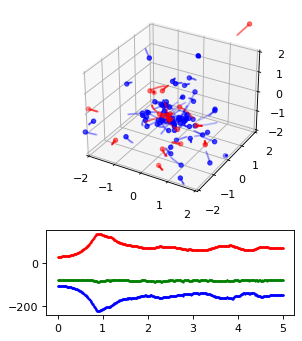

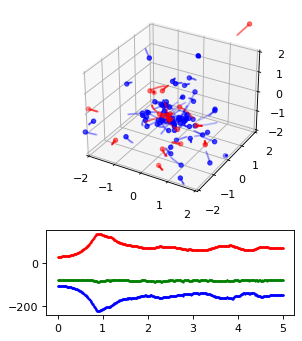

Number of collisions:  321.0
Baryon-DM collisions:  248
Cluster stats: intial, final 86 75


<Figure size 640x480 with 0 Axes>

CPU times: user 3.34 s, sys: 337 ms, total: 3.67 s
Wall time: 1.93 s


In [57]:
%%time
if __name__== "__main__":
  main()

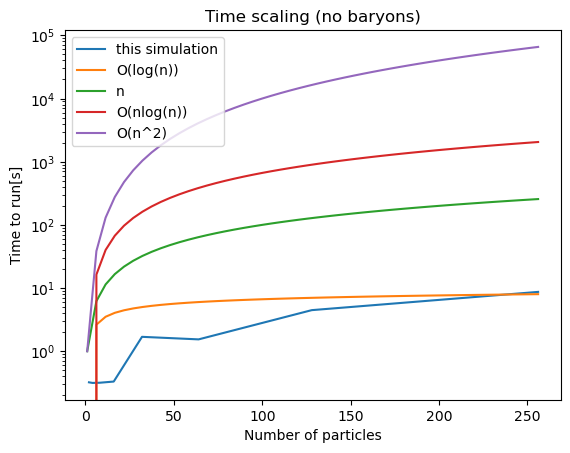

In [53]:
#Scalability 
particles = [2, 4, 8, 16, 32, 64, 128, 256]
time = [0.322, 0.315, 0.317, 0.331, 1.69, 1.54, 4.47, 8.69]

plt.title('Time scaling (no baryons)')
plt.xlabel('Number of particles')
plt.ylabel('Time to run[s]')
plt.yscale('log')
plt.plot(particles, time, label='this simulation')

n = np.linspace(1, 256)
plt.plot(n, 8.69*np.log2(n)/np.log2(256), label='O(log(n))')
plt.plot(n, 8.6*n/256, label='n')
plt.plot(n, 71*n*np.log2(n)/(256*np.log2(256)), label='O(nlog(n))')
plt.plot(n, 71*n**2/(256**2), label='O(n^2)')
plt.legend()
plt.show()


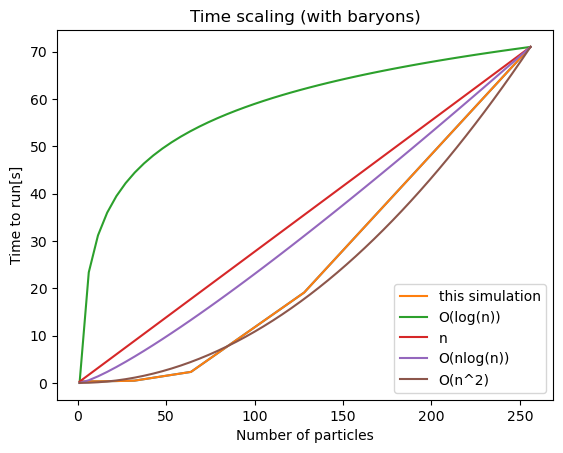

In [62]:
# scalability with interactions:
#sigma_b_b=0.2
#sigma_b_dm = 0.1
#fBaryon = 0.2
particles = [2, 4, 8, 16, 32, 64, 128, 256]
time=[0.315, 0.289, 0.332, 0.354, 0.476, 2.33, 19.1, 71]
plt.plot(particles, time)


plt.title('Time scaling (with baryons)')
plt.xlabel('Number of particles')
plt.ylabel('Time to run[s]')
#plt.yscale('log')
plt.plot(particles, time, label='this simulation')

n = np.linspace(1, 256)
# scaled all time complexities by a const to make it easier to compare to our simulation
plt.plot(n, 71*np.log2(n)/np.log2(256), label='O(log(n))')
plt.plot(n, 71*n/256, label='n')
plt.plot(n, 71*n*np.log2(n)/(256*np.log2(256)), label='O(nlog(n))')
plt.plot(n, 71*n**2/(256**2), label='O(n^2)')
plt.legend()
plt.show()